In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('601186', start='2021-09-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df



本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
162,2021-09-01,7.434,8.024,8.124,7.434,3517971.0,601186
163,2021-09-02,8.054,8.414,8.494,7.924,3186963.0,601186
164,2021-09-03,8.424,8.134,8.484,8.114,2308561.0,601186
165,2021-09-06,8.214,8.464,8.834,8.144,2972888.0,601186
166,2021-09-07,8.454,8.604,8.674,8.324,2016897.0,601186
...,...,...,...,...,...,...,...
238,2021-12-27,7.574,7.594,7.674,7.564,467699.0,601186
239,2021-12-28,7.594,7.504,7.624,7.454,549211.0,601186
240,2021-12-29,7.484,7.504,7.574,7.474,310533.0,601186
241,2021-12-30,7.484,7.474,7.524,7.454,419249.0,601186


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
162,7.434,8.024
163,8.054,8.414
164,8.424,8.134
165,8.214,8.464
166,8.454,8.604
...,...,...
238,7.574,7.594
239,7.594,7.504
240,7.484,7.504
241,7.484,7.474


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.2254902 , 0.54358974],
       [0.52941176, 0.74358974],
       [0.71078431, 0.6       ],
       [0.60784314, 0.76923077],
       [0.7254902 , 0.84102564],
       [0.78921569, 0.84102564],
       [0.79901961, 1.        ],
       [1.        , 0.96410256],
       [0.85294118, 0.95384615],
       [0.91176471, 0.74871795],
       [0.67156863, 0.71282051],
       [0.67156863, 0.68205128],
       [0.6372549 , 0.61025641],
       [0.51470588, 0.74358974],
       [0.73039216, 0.74358974],
       [0.70588235, 0.61025641],
       [0.57352941, 0.41538462],
       [0.39215686, 0.46153846],
       [0.41176471, 0.34358974],
       [0.33333333, 0.35384615],
       [0.44117647, 0.44102564],
       [0.41666667, 0.38974359],
       [0.34803922, 0.27692308],
       [0.25980392, 0.3025641 ],
       [0.27941176, 0.27179487],
       [0.25490196, 0.21538462],
       [0.20098039, 0.25641026],
       [0.2254902 , 0.26666667],
       [0.25      , 0.24102564],
       [0.22058824, 0.22051282],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(60, 2)
(21, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(40, 14, 2)
(40, 1)
(1, 14, 2)
(1, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 0.1172 - val_loss: 0.0158
Epoch 2/10
1/1 [==============================] - 0s 114ms/step - loss: 0.0978 - val_loss: 0.0078
Epoch 3/10
1/1 [==============================] - 0s 87ms/step - loss: 0.0783 - val_loss: 0.0023
Epoch 4/10
1/1 [==============================] - 0s 63ms/step - loss: 0.0665 - val_loss: 4.2405e-06
Epoch 5/10
1/1 [==============================] - 0s 81ms/step - loss: 0.0558 - val_loss: 0.0024
Epoch 6/10
1/1 [==============================] - 0s 84ms/step - loss: 0.0525 - val_loss: 0.0102
Epoch 7/10
1/1 [==============================] - 0s 75ms/step - loss: 0.0486 - val_loss: 0.0200
Epoch 8/10
1/1 [==============================] - 0s 69ms/step - loss: 0.0638 - val_loss: 0.0226
Epoch 9/10
1/1 [==============================] - 0s 58ms/step - loss: 0.0651 - val_loss: 0.0193
Epoch 10/10
1/1 [==============================] - 0s 56ms/step - loss: 0.0576 - val_loss: 0.0139


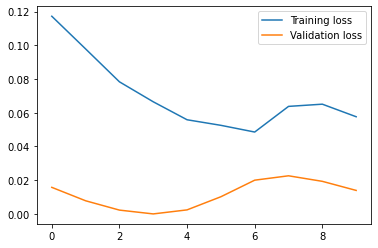

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 1s 1s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48809/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

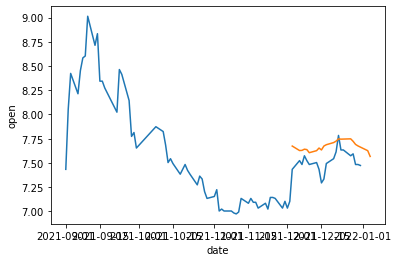

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [71]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("601186_ZGTJ.csv")

In [15]:
df.to_csv("601186_ZGTJ.csv")